In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils

Using TensorFlow backend.
C:\Users\subah\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\subah\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\subah\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\subah\anaconda3\envs\py36\lib\site-packag

In [2]:
PATH = 'training'

In [3]:
images=glob.glob(os.path.join(PATH,'images','*.tif'))
mask=glob.glob(os.path.join(PATH,'1st_manual','*.GIF'))

In [4]:
def get_data(path, resize_dim=512):
    img=cv2.imread(path,0)
    img_rz=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
    return img_rz

In [5]:
def get_data_gif(path, resize_dim=512):
    img=plt.imread(path)
    img_rz=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
    return img_rz

In [6]:
orig_images=np.array([get_data(path) for path in images])
orig_images.shape

(20, 512, 512)

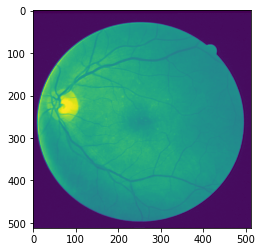

In [7]:
plt.imshow(orig_images[0])

In [8]:
masks=np.array([get_data_gif(path) for path in mask])
masks.shape

(20, 512, 512)

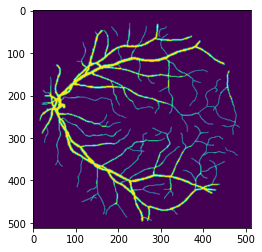

In [9]:
plt.imshow(masks[0])

In [10]:
orig_images = np.expand_dims(orig_images, axis = -1)
masks = np.expand_dims(masks, axis = -1)

In [11]:
masks.shape, orig_images.shape

((20, 512, 512, 1), (20, 512, 512, 1))

In [12]:
orig_images = orig_images / 255
masks = masks / 255

In [13]:
def get_unet():
    inputs = Input((512, 512, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [14]:
model = get_unet()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                  

In [15]:
model.fit(orig_images, masks, epochs = 500, batch_size= 16, shuffle = True, validation_split = 0.1)

Train on 18 samples, validate on 2 samples
Epoch 1/500
18/18 [==============================] - 31s 2s/step - loss: 0.6847 - accuracy: 0.8696 - val_loss: 0.6825 - val_accuracy: 0.8825
Epoch 2/500
18/18 [==============================] - 30s 2s/step - loss: 0.6804 - accuracy: 0.8747 - val_loss: 0.6780 - val_accuracy: 0.8826
Epoch 3/500
18/18 [==============================] - 30s 2s/step - loss: 0.6754 - accuracy: 0.8747 - val_loss: 0.6730 - val_accuracy: 0.8826
Epoch 4/500
18/18 [==============================] - 30s 2s/step - loss: 0.6698 - accuracy: 0.8747 - val_loss: 0.6677 - val_accuracy: 0.8826
Epoch 5/500
18/18 [==============================] - 31s 2s/step - loss: 0.6636 - accuracy: 0.8747 - val_loss: 0.6616 - val_accuracy: 0.8826
Epoch 6/500
18/18 [==============================] - 31s 2s/step - loss: 0.6568 - accuracy: 0.8747 - val_loss: 0.6543 - val_accuracy: 0.8826
Epoch 7/500
18/18 [==============================] - 31s 2s/step - loss: 0.6485 - accuracy: 0.8747 - val_loss: 

Epoch 116/500
18/18 [==============================] - 38s 2s/step - loss: 0.2568 - accuracy: 0.8747 - val_loss: 0.2493 - val_accuracy: 0.8826
Epoch 117/500
18/18 [==============================] - 37s 2s/step - loss: 0.2572 - accuracy: 0.8747 - val_loss: 0.2515 - val_accuracy: 0.8826
Epoch 118/500
18/18 [==============================] - 37s 2s/step - loss: 0.2588 - accuracy: 0.8747 - val_loss: 0.2476 - val_accuracy: 0.8826
Epoch 119/500
18/18 [==============================] - 37s 2s/step - loss: 0.2556 - accuracy: 0.8747 - val_loss: 0.2504 - val_accuracy: 0.8826
Epoch 120/500
18/18 [==============================] - 37s 2s/step - loss: 0.2586 - accuracy: 0.8747 - val_loss: 0.2474 - val_accuracy: 0.8826
Epoch 121/500
18/18 [==============================] - 38s 2s/step - loss: 0.2556 - accuracy: 0.8747 - val_loss: 0.2499 - val_accuracy: 0.8826
Epoch 122/500
18/18 [==============================] - 37s 2s/step - loss: 0.2579 - accuracy: 0.8747 - val_loss: 0.2475 - val_accuracy: 0.8826

18/18 [==============================] - 32s 2s/step - loss: 0.2503 - accuracy: 0.8747 - val_loss: 0.2367 - val_accuracy: 0.8826
Epoch 231/500
18/18 [==============================] - 32s 2s/step - loss: 0.2458 - accuracy: 0.8747 - val_loss: 0.2353 - val_accuracy: 0.8826
Epoch 232/500
18/18 [==============================] - 32s 2s/step - loss: 0.2417 - accuracy: 0.8747 - val_loss: 0.2259 - val_accuracy: 0.8826
Epoch 233/500
18/18 [==============================] - 31s 2s/step - loss: 0.2338 - accuracy: 0.8747 - val_loss: 0.2233 - val_accuracy: 0.8826
Epoch 234/500
18/18 [==============================] - 31s 2s/step - loss: 0.2302 - accuracy: 0.8747 - val_loss: 0.2228 - val_accuracy: 0.8826
Epoch 235/500
18/18 [==============================] - 31s 2s/step - loss: 0.2284 - accuracy: 0.8747 - val_loss: 0.2210 - val_accuracy: 0.8826
Epoch 236/500
18/18 [==============================] - 31s 2s/step - loss: 0.2265 - accuracy: 0.8747 - val_loss: 0.2194 - val_accuracy: 0.8826
Epoch 237/500

18/18 [==============================] - 32s 2s/step - loss: 0.1443 - accuracy: 0.9053 - val_loss: 0.1325 - val_accuracy: 0.9103
Epoch 345/500
18/18 [==============================] - 32s 2s/step - loss: 0.1418 - accuracy: 0.9057 - val_loss: 0.1321 - val_accuracy: 0.9106
Epoch 346/500
18/18 [==============================] - 32s 2s/step - loss: 0.1416 - accuracy: 0.9057 - val_loss: 0.1317 - val_accuracy: 0.9108
Epoch 347/500
18/18 [==============================] - 33s 2s/step - loss: 0.1411 - accuracy: 0.9056 - val_loss: 0.1311 - val_accuracy: 0.9110
Epoch 348/500
18/18 [==============================] - 33s 2s/step - loss: 0.1402 - accuracy: 0.9059 - val_loss: 0.1305 - val_accuracy: 0.9111
Epoch 349/500
18/18 [==============================] - 33s 2s/step - loss: 0.1396 - accuracy: 0.9063 - val_loss: 0.1301 - val_accuracy: 0.9111
Epoch 350/500
18/18 [==============================] - 34s 2s/step - loss: 0.1393 - accuracy: 0.9065 - val_loss: 0.1296 - val_accuracy: 0.9112
Epoch 351/500

18/18 [==============================] - 43s 2s/step - loss: 0.1201 - accuracy: 0.9114 - val_loss: 0.1134 - val_accuracy: 0.9140
Epoch 459/500
18/18 [==============================] - 43s 2s/step - loss: 0.1198 - accuracy: 0.9115 - val_loss: 0.1118 - val_accuracy: 0.9147
Epoch 460/500
18/18 [==============================] - 43s 2s/step - loss: 0.1202 - accuracy: 0.9113 - val_loss: 0.1128 - val_accuracy: 0.9141
Epoch 461/500
18/18 [==============================] - 42s 2s/step - loss: 0.1193 - accuracy: 0.9117 - val_loss: 0.1130 - val_accuracy: 0.9141
Epoch 462/500
18/18 [==============================] - 42s 2s/step - loss: 0.1200 - accuracy: 0.9117 - val_loss: 0.1117 - val_accuracy: 0.9146
Epoch 463/500
18/18 [==============================] - 41s 2s/step - loss: 0.1197 - accuracy: 0.9118 - val_loss: 0.1108 - val_accuracy: 0.9149
Epoch 464/500
18/18 [==============================] - 41s 2s/step - loss: 0.1191 - accuracy: 0.9116 - val_loss: 0.1127 - val_accuracy: 0.9143
Epoch 465/500

In [16]:
PATH1 = 'test'

In [17]:
t_images=glob.glob(os.path.join(PATH1,'images','*.tif'))

In [18]:
test_images=np.array([get_data(path) for path in t_images])
test_images.shape

(20, 512, 512)

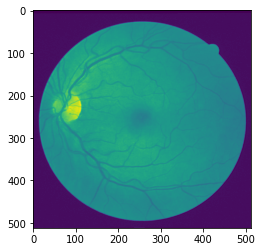

In [19]:
plt.imshow(test_images[0])

In [20]:
test_images = np.expand_dims(test_images, axis = -1)

In [21]:
test_images.shape

(20, 512, 512, 1)

In [22]:
test_images = test_images / 255

In [23]:
imgs_mask_test = model.predict(test_images, verbose=1)

20/20 [==============================] - 10s 501ms/step


In [24]:
idx = random.randint(0, len(imgs_mask_test))
i = imgs_mask_test[idx]
i = i[:, :, 0]
i.shape

(512, 512)

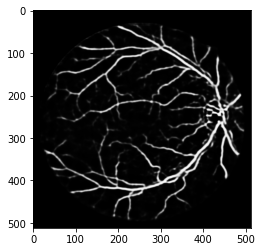

In [25]:
plt.imshow(i, cmap='gray')

In [26]:
yp = np.round(imgs_mask_test,0)

In [27]:
idx = random.randint(0, len(yp))
i = imgs_mask_test[idx]
i = i[:, :, 0]
i.shape

(512, 512)

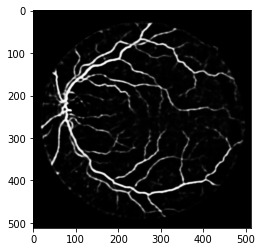

In [28]:
plt.imshow(i, cmap='gray')